# Using finite differences to solve differential equations

## Stationary equations - without time

### Setup
We are given $u_{xx} + u_{yy} = f(x, y)$ and boundary $\Omega$ such that $u(\Omega)$ are provided.

Inputs are:
- $N_{x}$
- $N_{y}$

### Problem
approximate u(x, y)...

### Solution
- Select the operator to approximate $\nabla^{2}$, e.g. $\Lambda u_{i} = \frac{u_{i+1} - 2u_{i} + u_{i-1}}{h^{2}}$
- Given $N_{x}$ and $N_{y}$ and the boundary, e.g. $[0, 1]$ for both x and y, we basically have a 2D network
- For every point of the network (i, j) (not on the boundary) we write down
    
    $\Lambda_{i}u_{ij} + \Lambda_{j}u_{ij} = f(x_{i}, y_{j})$
    
- For every point on the boundary, equation is basically taking the form of a boundary condition

    $u(\Omega)$ = some values
    
- We basically gonna get this: $\textbf{A} u = b$, where matrix $\textbf{A}$ has dimensions of $N_{p} \times N_{p}$, where $N_{p}$ is the number of points in the network and $N_{p} = N_{x} \times N_{y}$
- Solve $\textbf{A} u = b$


## Nonstationary equations - with time

### Setup
We are given 
- $u_{xx} + u_{yy} = f(x, y)$ - Poisson equation on rectangular boundary: x $\epsilon$ [a, b], y $\epsilon$ [c, d]
- u is known on the boundary - Dirichlet boundary conditions
- Apply the "determination" (may be this guy has a different name) method:

    $u_{t} = u_{xx} + u_{yy} - f(x, y)$ with the following operator's approximation (just as an example)
    
    $\frac{u^{n+1}_{i} - u^{n}_{i}}{\tau} = \Lambda u^{n}_{i} - f_{i}$ with $\Lambda$ defined as above

Inputs are:
- f(x, y)
- u on the boundary
- at t=0 $u^{0}(x, y) = C$, we need to select const C
- $\tau$ - step in time
- $N_{x}$ - number of steps in x => we do know $h_{1}$
- $N_{y}$ - number of steps in y => we do know $h_{2}$
- $\epsilon$

### Problem
Approximate so that

$max_{ij}$ $\frac{|u^{n+1}_{ij} - u^{n}_{ij}|}{\tau} < \epsilon$

### Solution
we basically need to keep solving $\textbf{A}u = b$ until we converge on all points of the network...

```python
# at time t = 0
# u is known and equals C everywhere...
u_array = ...

# for each t >= 1
while (!condSatisfied):
    A = compute_A(u_array, ...)
    b = compute_b(...)
    u_new_array = ... # solve (Au = b)
    max_diff = max(abs(u_new_array - u_array))
    condSatsfied = max_diff/tau < eps
```

In [124]:
import matplotlib.pyplot as plt
import numpy as np

## Let's solve the original problem but for a simple 1d case and using a simple approximation defined just above
- $u_{xx} = f(x)$
- $u(x) = cos(x) sin(x)$
- $f(x) = -2sin(2x)$
- for x $\epsilon$ [0, 2$\pi$]

### 1. Plot the result

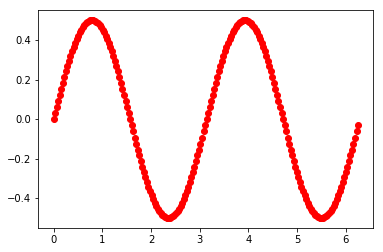

In [20]:
t1 = np.arange(0, 2*np.pi, 0.01*np.pi, np.float32)
plt.plot(t1, np.sin(t1)*np.cos(t1), 'ro')
plt.show()

### 2. At time t=0, we have

In [133]:
# helper to fill in the f-values
def give_me_func(Nx, delta):
    def func(i):
        x = i*delta
        return -2*np.sin(2*x)
    return func

Nx = 10
eps = 0.1
tau = 0.1
x_start = 0
x_end = 2*np.pi
x_delta = (x_end - x_start) / (Nx - 1)
C = 0
u_values = np.zeros((Nx))
u_values.fill(C)
u_gold_func = lambda x: np.cos(x) * np.sin(x)
f_values = np.fromfunction(give_me_func(Nx, x_delta), (Nx,), dtype=float)

In [134]:
print u_values
print f_values

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-0.00000000e+00 -1.96961551e+00 -6.84040287e-01  1.73205081e+00
  1.28557522e+00 -1.28557522e+00 -1.73205081e+00  6.84040287e-01
  1.96961551e+00  9.79717439e-16]


### 3. Define computations we need to perform
- computing matrix A
- computing vector b
- solver for $\textbf{A}u = b$

In [135]:
# TODO: this is a simple case - identity matrix for A...
def compute_matrix_A(u_values, f_values, tau, x_delta, Nx):
    def func(i, j):
        return 1
    
    return func

def compute_vector_b(u_values, u_gold_func, f_values, tau, x_start, x_delta, Nx):
    b = np.zeros((Nx))
    indices = np.arange(0, Nx, 1, np.int32)
    
    # on the boundary, return the boundary condition value
    b[0] = u_gold_func(x_start)
    b[Nx-1] = u_gold_func(x_start + x_delta*(Nx-1))
    
    # otherwise compute the value
    x_delta_2 = x_delta*x_delta
    i_slice = indices[1:Nx-1]
    b[i_slice] = u_values[i_slice] + (tau/x_delta_2 *
        (u_values[i_slice+1] - 2*u_values[i_slice] + u_values[i_slice-1]) - f_values[i_slice]*tau)
    return b

def compute_max_eps(u_new, u, tau):
    return np.amax(np.abs(u_new - u))/tau

In [136]:
# main minimization loop. 
condSatisfied = False
iterations = 0
max_iterations = 100
while not condSatisfied and iterations < max_iterations:
    b = compute_vector_b(u_values, u_gold_func, f_values, tau, x_start, x_delta, Nx)
    u_values_new = b # simple here
    max_eps = compute_max_eps(u_values_new, u_values, tau)
    print u_values
    print u_values_new
    if max_eps < eps: 
        condSatisfied = True
    u_values = u_values_new
    iterations += 1
    print iterations, max_eps, eps

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.00000000e+00  1.96961551e-01  6.84040287e-02 -1.73205081e-01
 -1.28557522e-01  1.28557522e-01  1.73205081e-01 -6.84040287e-02
 -1.96961551e-01 -2.44929360e-16]
1 1.9696155060244163 0.1
[ 0.00000000e+00  1.96961551e-01  6.84040287e-02 -1.73205081e-01
 -1.28557522e-01  1.28557522e-01  1.73205081e-01 -6.84040287e-02
 -1.96961551e-01 -2.44929360e-16]
[ 0.00000000e+00  3.27134596e-01  1.13612653e-01 -2.87677336e-01
 -2.13521943e-01  2.13521943e-01  2.87677336e-01 -1.13612653e-01
 -3.27134596e-01 -2.44929360e-16]
2 1.301730457034777 0.1
[ 0.00000000e+00  3.27134596e-01  1.13612653e-01 -2.87677336e-01
 -2.13521943e-01  2.13521943e-01  2.87677336e-01 -1.13612653e-01
 -3.27134596e-01 -2.44929360e-16]
[ 0.00000000e+00  4.13166727e-01  1.43491298e-01 -3.63332722e-01
 -2.69675428e-01  2.69675428e-01  3.63332722e-01 -1.43491298e-01
 -4.13166727e-01 -2.44929360e-16]
3 0.8603213051425701 0.1
[ 0.00000000e+00  4.13166727e-01  1.43491298e-01 -3.63332722e-01
 -2.69675

### Plot the result

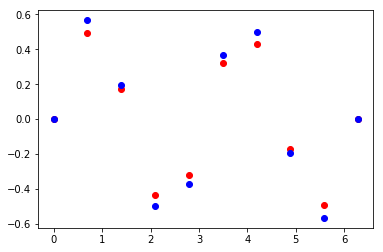

In [137]:
t1 = np.arange(0, 2*np.pi+0.5*x_delta, x_delta, np.float32)
plt.plot(t1, np.sin(t1)*np.cos(t1), 'ro', t1, u_values, 'bo')
plt.show()

In [138]:
print np.sin(t1)*np.cos(t1)
print u_values

[ 0.0000000e+00  4.9240384e-01  1.7101011e-01 -4.3301275e-01
 -3.2139388e-01  3.2139364e-01  4.3301263e-01 -1.7101003e-01
 -4.9240389e-01 -3.0199161e-07]
[ 0.00000000e+00  5.66872345e-01  1.96872699e-01 -4.98499174e-01
 -3.69999646e-01  3.69999646e-01  4.98499174e-01 -1.96872699e-01
 -5.66872345e-01 -2.44929360e-16]
